# Momentum Strategies

Momentum or trend-following strategies refer to trading strategies that rely on following a price trend to completion for profit. An example of a price trend is a sustained price increase due to good earnings beating expectations. 

Momentum strategies use various technical indicators to open a trade when a trend begins and exits when the trend ends. These strategies can be long or short. Momentum strategies is usually contrasted with mean-reversion strategies where traders believe that prices should revert to an expected value. An example of a mean reversion strategy is pairs trading.

Momentum strategies are generally characterised by a low win-rate due to whipsaw losses (indicated trends did not materialise) with great returns from a few winning trades, compared to lower, but more consistent profits for mean reversion trades. This generally produces a lower sharpe ratio for momentum strategies.

Technical indicators for entry include:
- Moving average crossover
- Breakout from highest value in rolling window
- Breakout from All-Time-High

Exit indicators include:
- Moving average crossover
- Breakout from lowest value in rolling window
- Trailing stop



In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from utils import misc
import datetime as dt
from trade_obj import *
from simple_backtester import backTester
from mpl_toolkits.mplot3d import Axes3D



ticker = 'SPY'
df = pd.read_csv('datasets/stock_price_series/' + ticker + '.csv')
df = misc.clean_df(df)
df = df.set_index('date')

Generate indicators for entry and exit

In [18]:
def generate_high_low(df, high_window, low_window):

    df['up_bound'] = df['high'].shift(1).rolling(high_window).max()
    df['low_bound'] = df['low'].shift(1).rolling(low_window).min()

    return df

def generate_atr(df, window):
    df['High-Low'] = df['high'] - df['low']
    df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
    df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window).mean()

    return df

def generate_sma(df, long_window, short_window):
    df['long_sma'] = df['close'].rolling(long_window).mean().shift(2)
    df['short_sma'] = df['close'].rolling(short_window).mean().shift(2)

    return df

### High Window with trailing stop loss

In [19]:
def hatr_backtest(df, high_window, atr_window, atr_multiple):

    df = generate_high_low(df, high_window, 10)
    df = generate_atr(df, atr_window)
    df['ATR'] = df['ATR'].shift(1)
    atr = df['ATR'].to_numpy()

    df.dropna(inplace=True)

    df['signal'] = 0

    # Generate trading signals
    df.loc[df['high'].shift(1) > df['up_bound'].shift(2), 'signal'] = 1    

    trades_arr = df['signal'].to_numpy()

    bt = backTester()
    bt.set_asset(df)

    tl = tradeList()

    open_trade = None
    stop_loss = np.nan
    stop_arr = []
    

    for i in range(len(bt.df)):
        
        order_quantity = 0
        order_price = 0
        

        if trades_arr[i] == 1 and open_trade == None:
    
            # order price at breakout
            order_price = bt.open[i]
            # order 1 unit
            order_quantity = bt.cash // order_price
            # open trade on record
            open_trade = trade(bt.date[i], order_price, order_quantity)
            n3 = atr_multiple * atr[i]
            stop_loss = order_price - n3
        # open trades present 
        elif open_trade != None:
            stop_loss = max(stop_loss, bt.high[i] - n3)
            if bt.low[i] < stop_loss:

                order_price = stop_loss
                order_quantity = -open_trade.quantity
                    
                open_trade.close(bt.date[i], order_price)
                tl.append(open_trade)
                
                open_trade = None
                stop_loss = np.nan
        
        stop_arr.append(stop_loss)

        bt.take_action(order_quantity=order_quantity, order_price=order_price)
    bt.df['stop_loss'] = stop_arr

    return bt, tl

In [20]:
hl_period = np.arange(5, 501, 5)
atr_range = np.arange(1, 11, 1)
results = []

for i in range(len(hl_period)):
    for j in range(len(atr_range)):
        # print(i, j)
        bt, _ = hatr_backtest(df.copy(), hl_period[i], 20, atr_range[j])
        bt.analyse()
        results.append((hl_period[i], atr_range[j], bt.annual_return, bt.annual_vol, bt.sharpe))

In [21]:
print('Buy Hold Results')
print(f'Annual Return = {bt.buy_hold_annual_return}')
print(f'Annual Volatility = {bt.buy_hold_annual_vol}')
print(f'Sharpe Ratio = {bt.buy_hold_sharpe}')
print('-----------')
best_sr = max(results, key=lambda x: x[2])
print(f'Max Total Returns:')
print(f'High Window = {best_sr[0]}, ATR multiple = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')
best_sr = max(results, key=lambda x: x[4])
print(f'Max Sharpe Ratio:')
print(f'High Window = {best_sr[0]}, ATR multiple = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')


Buy Hold Results
Annual Return = 0.1510179826977729
Annual Volatility = 0.19348402485693794
Sharpe Ratio = 0.7805191297288526
-----------
Max Total Returns:
High Window = 500, ATR multiple = 1
Annual Return = 0.11937322646871329
Annual Volatility = 0.19380600808484913
Sharpe Ratio = 0.6159418257892767
-----------
Max Sharpe Ratio:
High Window = 115, ATR multiple = 10
Annual Return = 0.11470675709639333
Annual Volatility = 0.12719036907414774
Sharpe Ratio = 0.9018509650642111
-----------


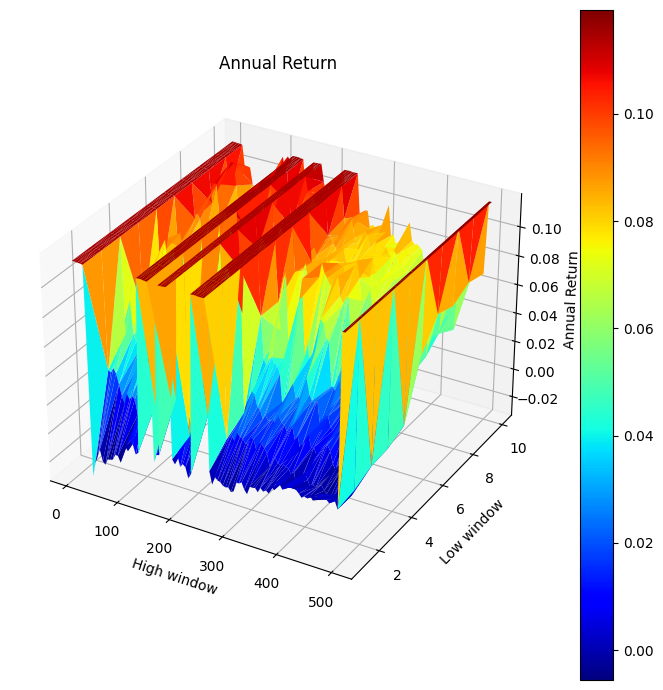

In [22]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[2] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Return')

fig.tight_layout()

plt.show()

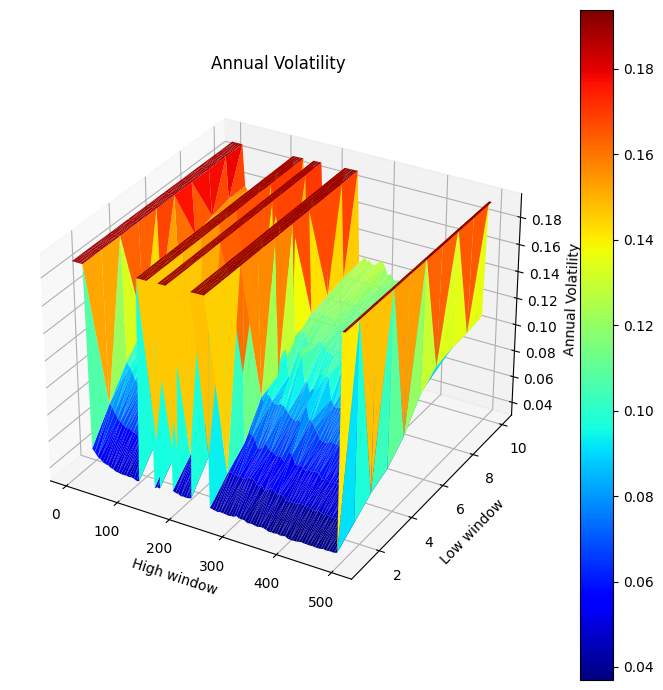

In [23]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[3] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Volatility')
ax.set_title('Annual Volatility')

fig.tight_layout()

plt.show()

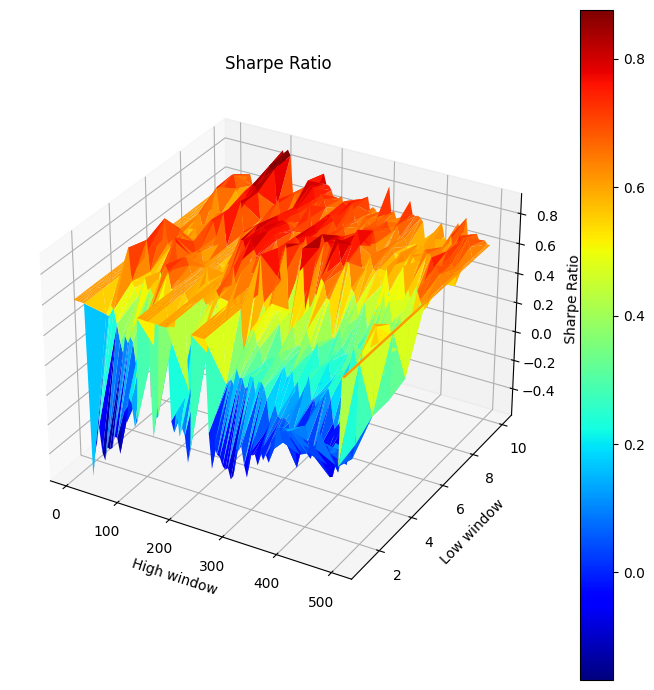

In [24]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[4] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio')

fig.tight_layout()

plt.show()

### Portfolio Stats

This section looks at the stats of a portfolio that runs this trade at no leverage.

This portfolio has lower returns and lower volatility/drawdowns compared to a buy-hold strategy. The portfolio manages to avoid the large drawdown events, thus preserving capital.

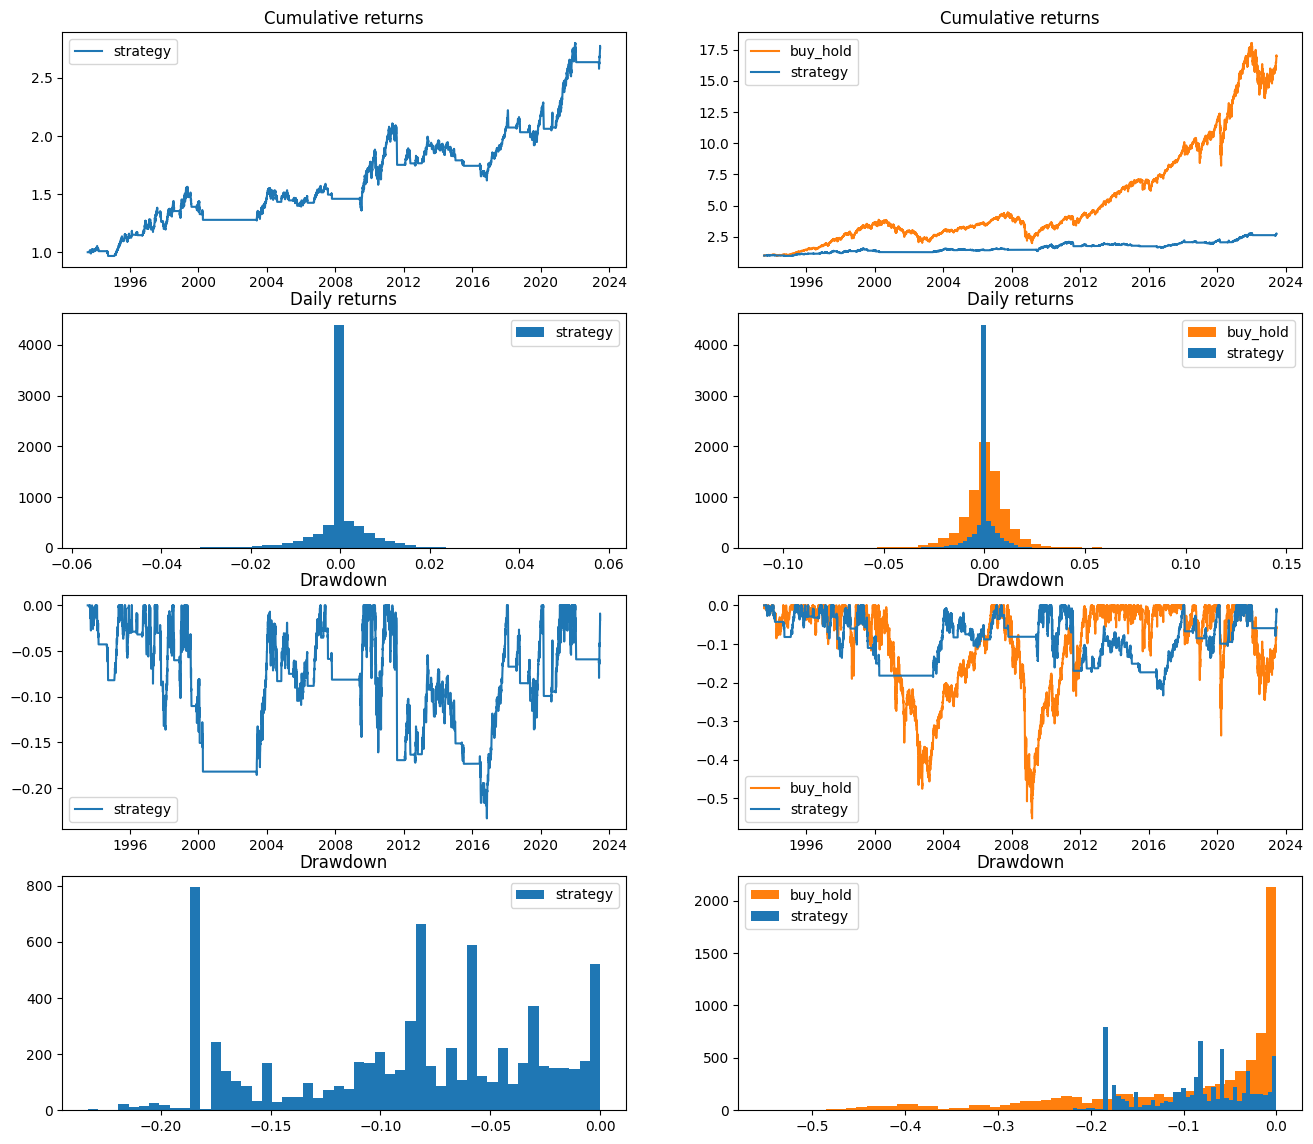

In [33]:
# bt, tl = hatr_backtest(df.copy(), best_sr[0], 20, best_sr[1])
bt, tl = hatr_backtest(df.copy(), best_sr[0], 20, 5)

bt.analyse()
bt.plot_graphs()

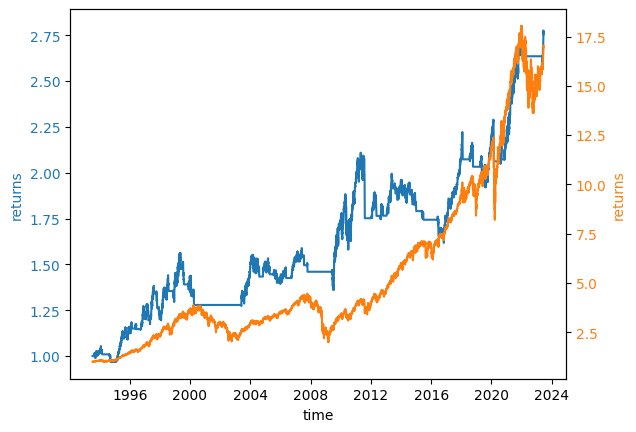

In [34]:
fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('returns', color=color)
ax1.plot(bt.date, bt.records['cum_returns'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'C1'
ax2 = ax1.twinx()
ax2.set_ylabel('returns', color=color)
ax2.plot(bt.date, bt.records['buy_hold_cum_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_facecolor('xkcd:white')
plt.show()

In [35]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print('---------')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print('---------')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          0.050371750037460084
buy_hold annual return:     0.14715978137822594
---------
Annualised vol:             0.09196212014522757
buy_hold annual vol:        0.18967766705127742
---------
Sharpe ratio:               0.5477445491460231
buy_hold Sharpe ratio:      0.7758413716594416


### Trade record stats

This section looks at the backtest results on a trade-by-trade basis.

In [36]:
tl.analyse(bt.df)
tl.stats

{'num_wins': 24,
 'num_loss': 22,
 'win_rate': 0.5217391304347826,
 'profit_total': 1635519.111246108,
 'profit_mean': 35554.76328795887,
 'returns_mean': 0.023937752625455992,
 'returns_std': 0.07723166995119413,
 'time_in_trade_mean': 116.82608695652173,
 'time_in_trade_std': 157.25680403549774,
 'capital_at_risk_mean': 1523783.794923036,
 'win_returns_mean': 0.07167621523559285,
 'win_returns_std': 0.08023384340669543,
 'win_profit_mean': 107188.85964202881,
 'win_time_in_trade_mean': 192.25,
 'win_time_in_trade_std': 188.3524102176094,
 'loss_returns_mean': -0.028140570221966036,
 'loss_returns_std': 0.016887145555565346,
 'loss_profit_mean': -42591.52364375379,
 'loss_time_in_trade_mean': 34.54545454545455,
 'loss_time_in_trade_std': 23.300781251417447}

We plot every single trade to view the characteristics of each trade.

trade 0
entry: [45.8125]
cost_basis: 45.8125
exit: 46.21875
returns: 0.008867667121418827


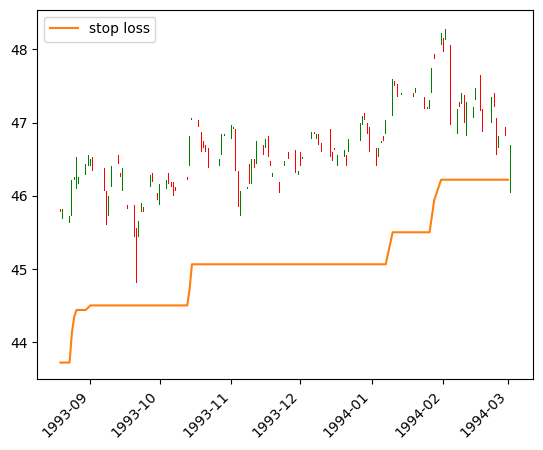

trade 1
entry: [47.8125]
cost_basis: 47.8125
exit: 45.8515625
returns: -0.04101307189542484


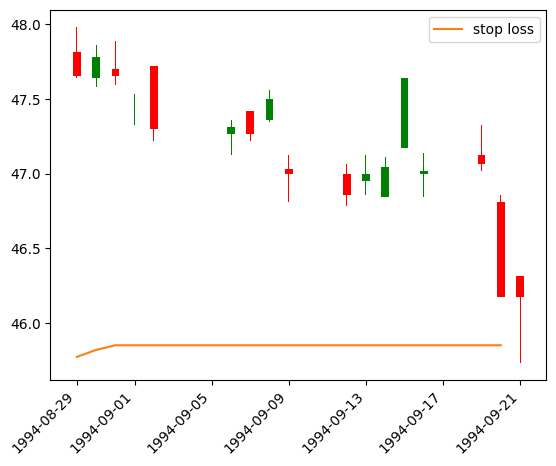

trade 2
entry: [48.015625]
cost_basis: 48.015625
exit: 55.07421875
returns: 0.14700618288317605


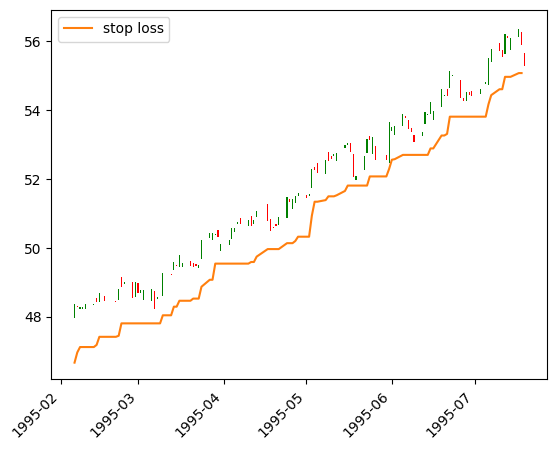

trade 3
entry: [56.453125]
cost_basis: 56.453125
exit: 57.30078125
returns: 0.015015222806531968


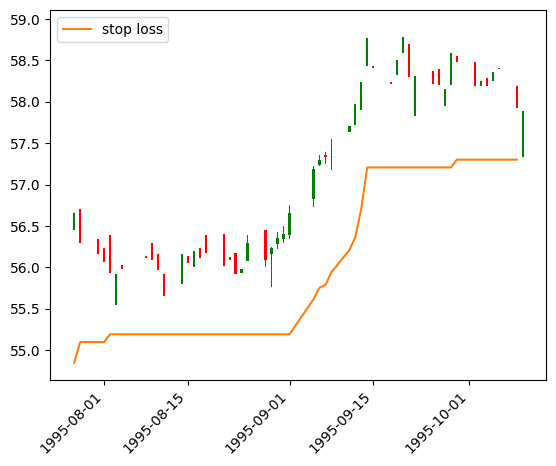

trade 4
entry: [58.875]
cost_basis: 58.875
exit: 57.3203125
returns: -0.026406581740976647


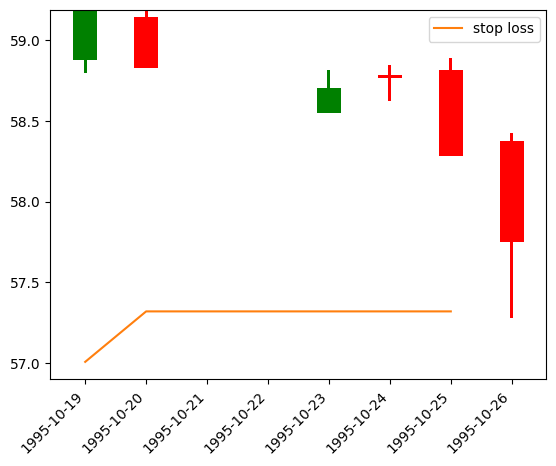

trade 5
entry: [59.21875]
cost_basis: 59.21875
exit: 60.7421875
returns: 0.025725593667546173


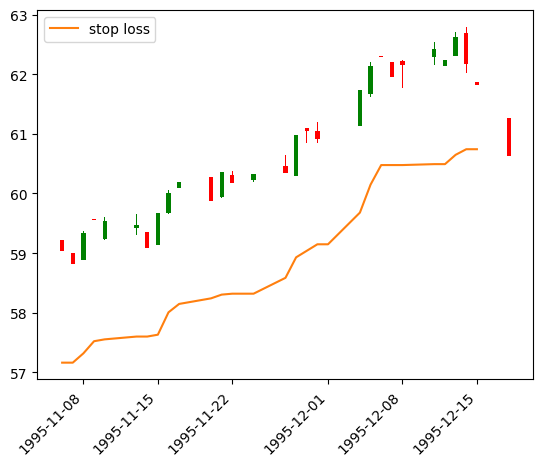

trade 6
entry: [63.0]
cost_basis: 63.0
exit: 64.41796875
returns: 0.022507440476190476


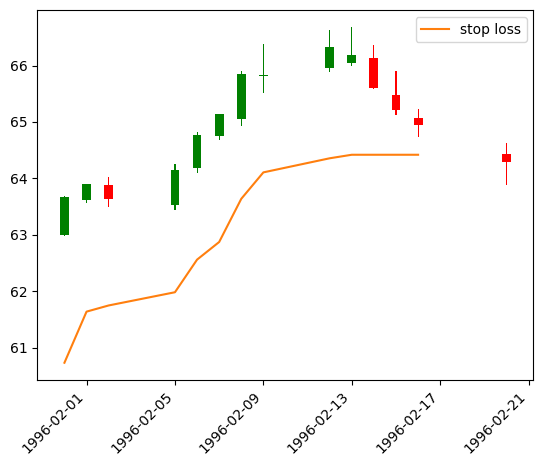

trade 7
entry: [66.78125]
cost_basis: 66.78125
exit: 66.5703125
returns: -0.0031586335985025736


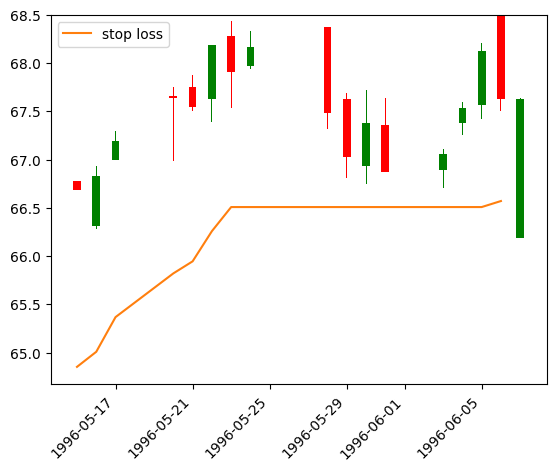

trade 8
entry: [68.65625]
cost_basis: 68.65625
exit: 72.03515625
returns: 0.049214838416021846


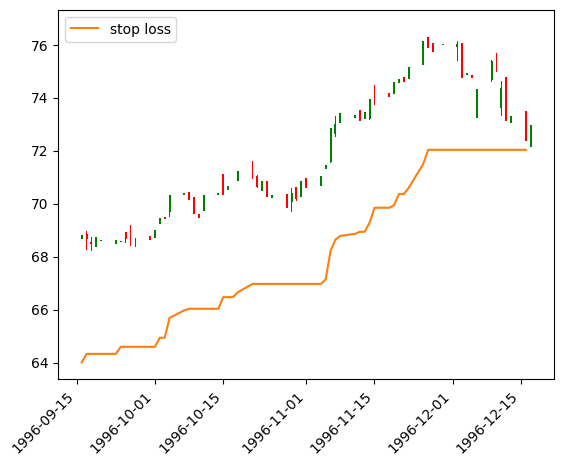

trade 9
entry: [76.71875]
cost_basis: 76.71875
exit: 76.203125
returns: -0.006720977596741344


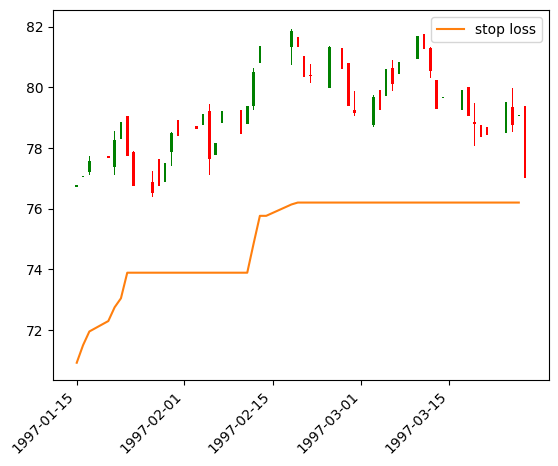

trade 10
entry: [82.96875]
cost_basis: 82.96875
exit: 93.12890625
returns: 0.12245762711864407


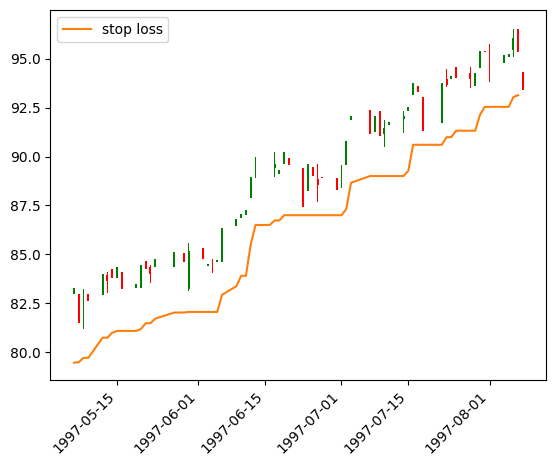

trade 11
entry: [97.3125]
cost_basis: 97.3125
exit: 91.5703125
returns: -0.059007707129094415


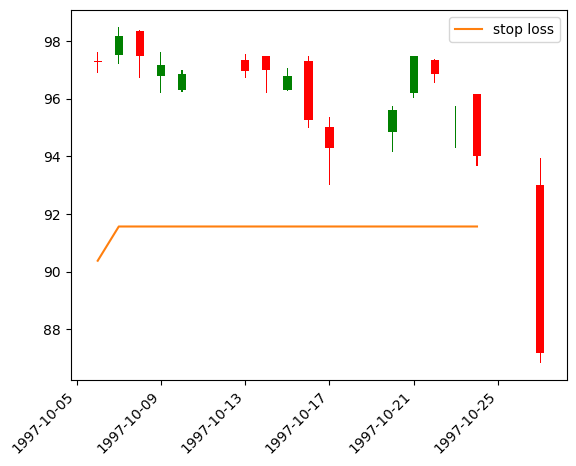

trade 12
entry: [98.5]
cost_basis: 98.5
exit: 93.6875
returns: -0.04885786802030457


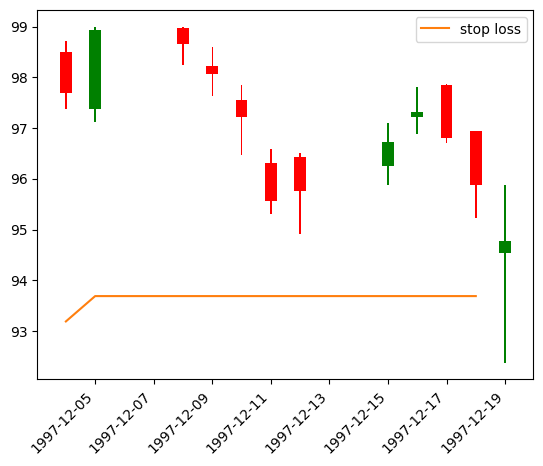

trade 13
entry: [98.78125]
cost_basis: 98.78125
exit: 111.4375
returns: 0.128124011388801


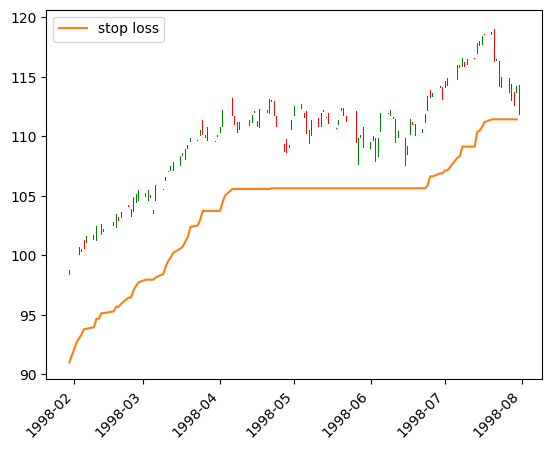

trade 14
entry: [119.0]
cost_basis: 119.0
exit: 129.55859375
returns: 0.08872767857142858


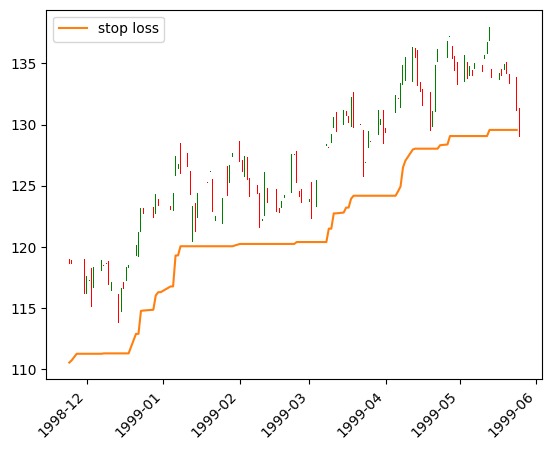

trade 15
entry: [138.125]
cost_basis: 138.125
exit: 130.27734375
returns: -0.056815610859728506


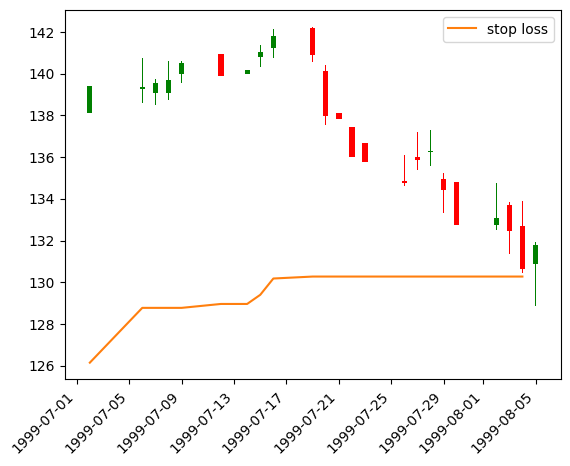

trade 16
entry: [142.25]
cost_basis: 142.25
exit: 135.79296875
returns: -0.04539213532513181


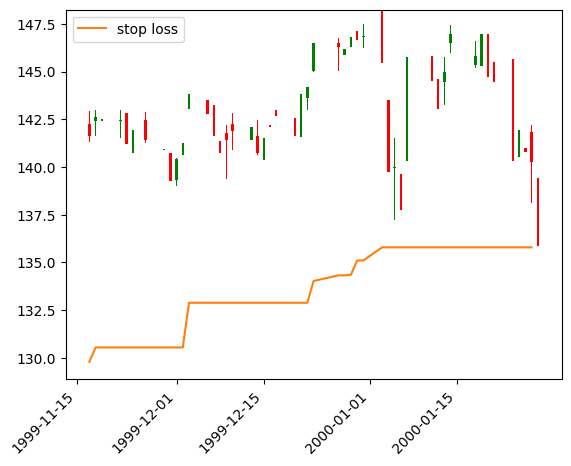

trade 17
entry: [149.5625]
cost_basis: 149.5625
exit: 144.03125
returns: -0.0369828666945257


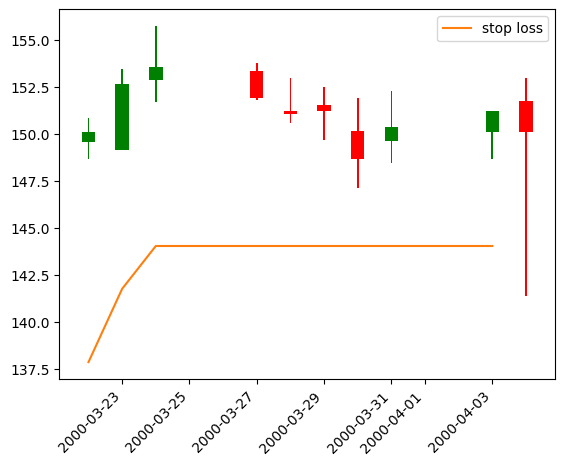

trade 18
entry: [95.8499984741211]
cost_basis: 95.8499984741211
exit: 107.46249961853029
returns: 0.12115285685209999


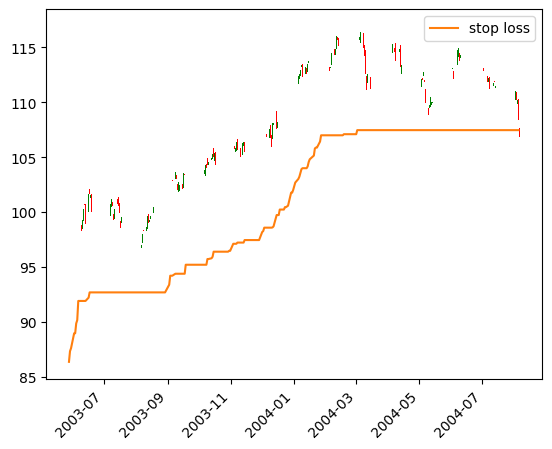

trade 19
entry: [114.77999877929688]
cost_basis: 114.77999877929688
exit: 115.77999687194824
returns: 0.008712302694602738


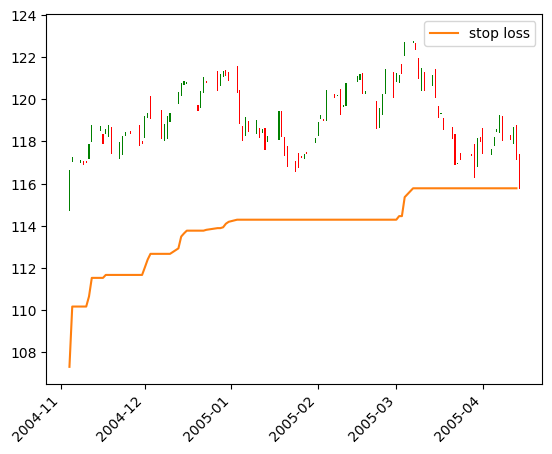

trade 20
entry: [122.79000091552734]
cost_basis: 122.79000091552734
exit: 118.8699970245361
returns: -0.03192445526316091


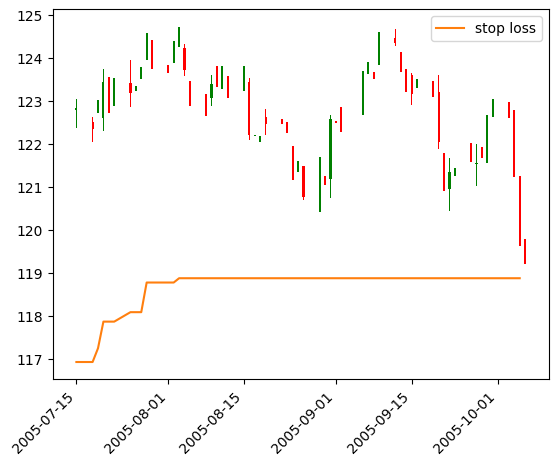

trade 21
entry: [125.1500015258789]
cost_basis: 125.1500015258789
exit: 127.43500900268555
returns: 0.01825814981180116


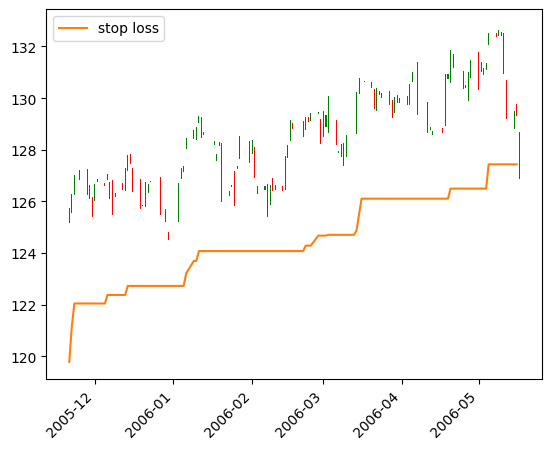

trade 22
entry: [132.5]
cost_basis: 132.5
exit: 140.87751007080078
returns: 0.06322649110038325


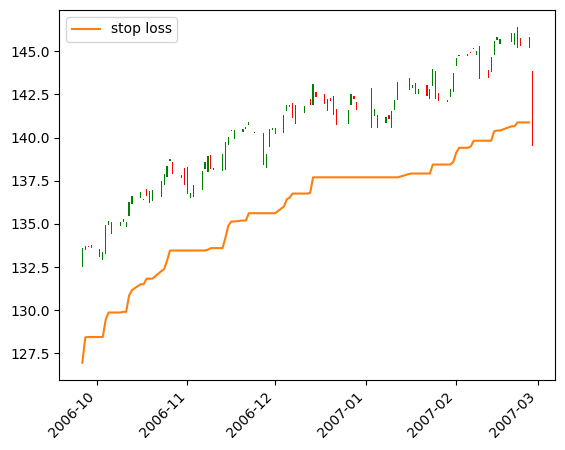

trade 23
entry: [146.97000122070312]
cost_basis: 146.97000122070312
exit: 149.73748779296875
returns: 0.018830282025443568


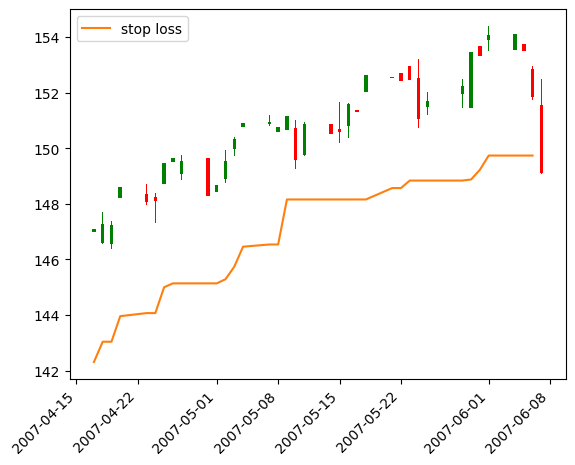

trade 24
entry: [154.57000732421875]
cost_basis: 154.57000732421875
exit: 149.74249267578125
returns: -0.03123189764953257


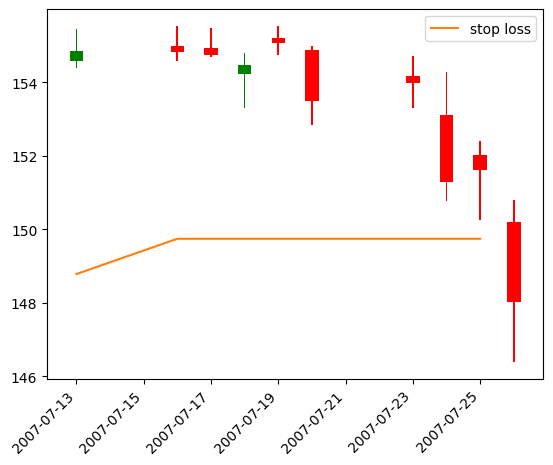

trade 25
entry: [155.38999938964844]
cost_basis: 155.38999938964844
exit: 151.6450080871582
returns: -0.024100594100006884


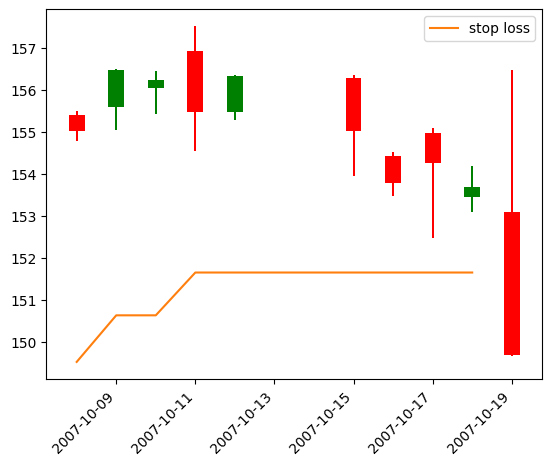

trade 26
entry: [94.4000015258789]
cost_basis: 94.4000015258789
exit: 113.30249404907227
returns: 0.20023826501752134


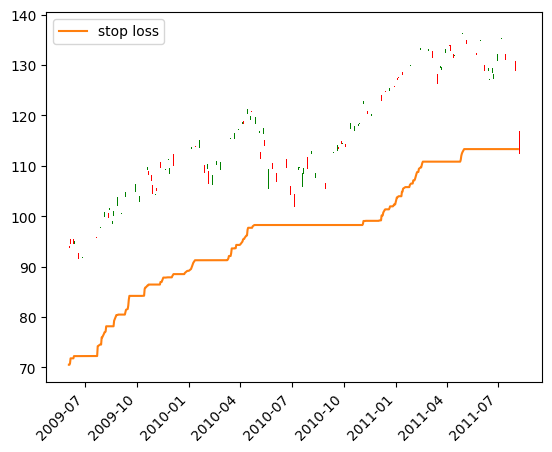

trade 27
entry: [131.22000122070312]
cost_basis: 131.22000122070312
exit: 132.1674976348877
returns: 0.0072206706704029495


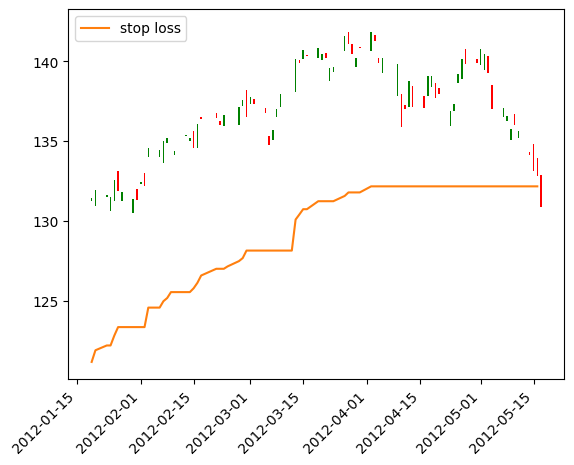

trade 28
entry: [141.97999572753906]
cost_basis: 141.97999572753906
exit: 142.0624885559082
returns: 0.000581017261948966


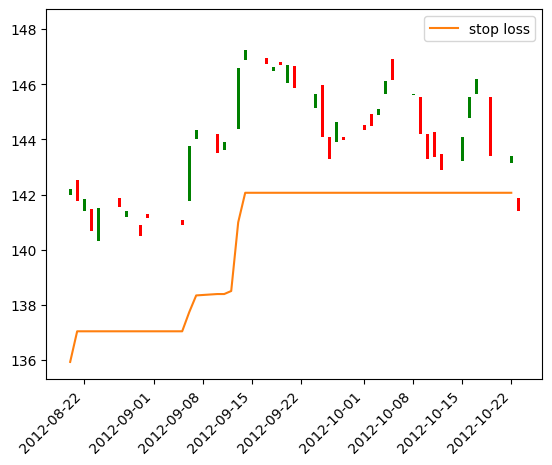

trade 29
entry: [147.97000122070312]
cost_basis: 147.97000122070312
exit: 160.4875144958496
returns: 0.08459493932473594


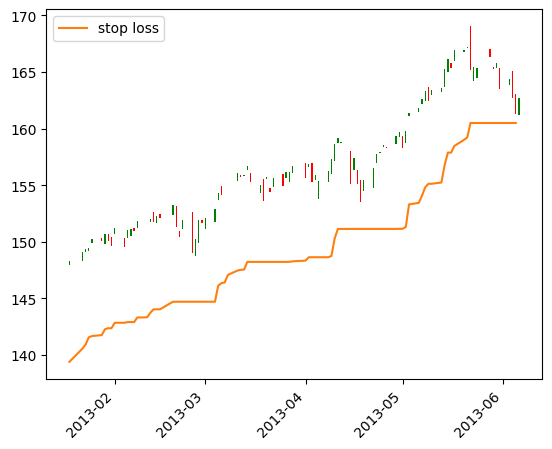

trade 30
entry: [168.52000427246094]
cost_basis: 168.52000427246094
exit: 166.11748123168945
returns: -0.014256604437815682


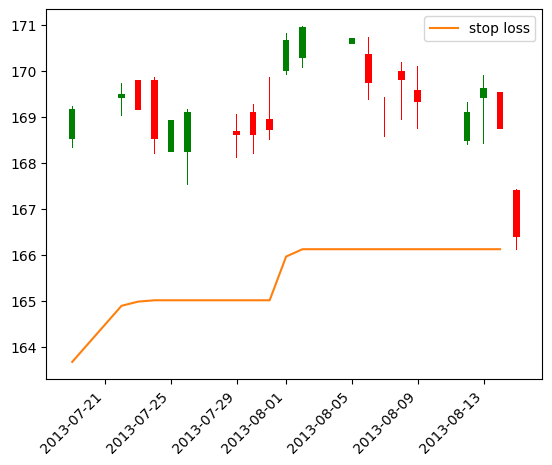

trade 31
entry: [170.4600067138672]
cost_basis: 170.4600067138672
exit: 167.322509765625
returns: -0.018406059044153184


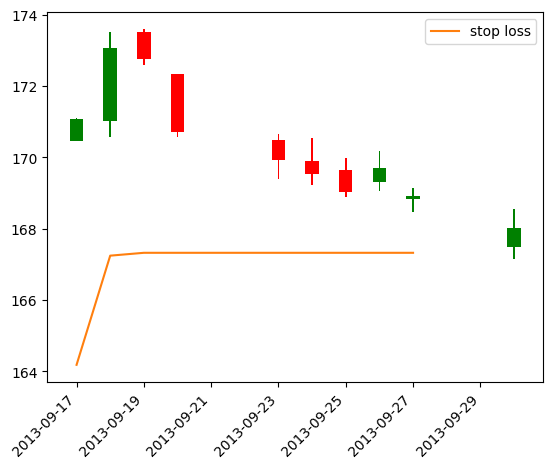

trade 32
entry: [174.4499969482422]
cost_basis: 174.4499969482422
exit: 176.6699981689453
returns: 0.012725716592369906


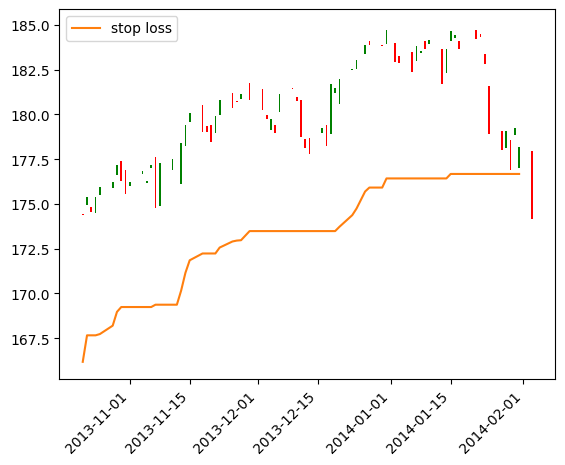

trade 33
entry: [183.2700042724609]
cost_basis: 183.2700042724609
exit: 181.92499542236328
returns: -0.007338947011198033


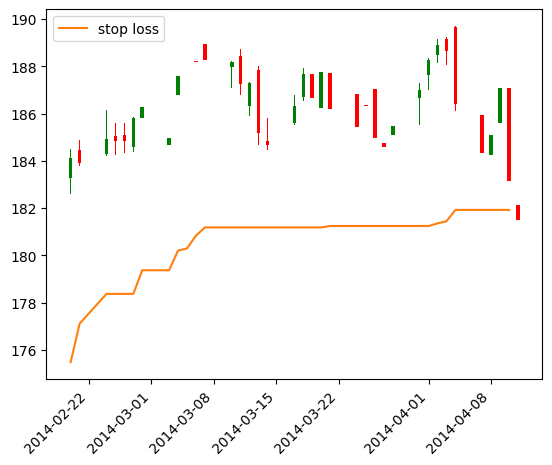

trade 34
entry: [190.0399932861328]
cost_basis: 190.0399932861328
exit: 191.98000717163083
returns: 0.010208450610588296


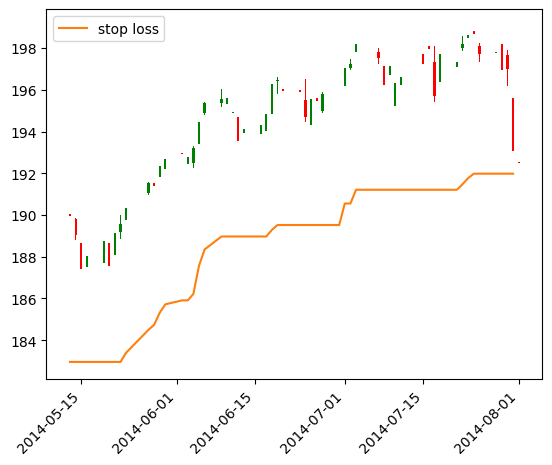

trade 35
entry: [199.08999633789065]
cost_basis: 199.08999633789065
exit: 193.44248962402344
returns: -0.028366602128428425


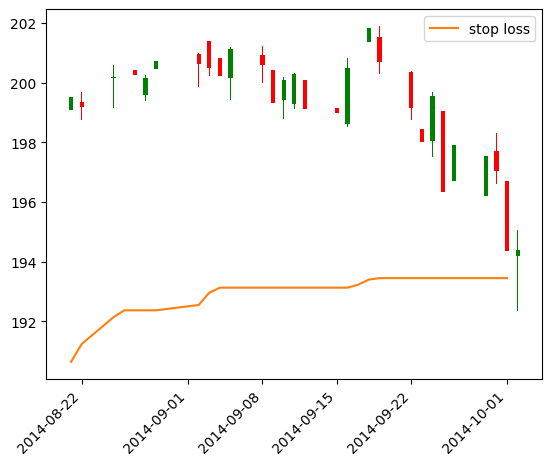

trade 36
entry: [201.22999572753903]
cost_basis: 201.22999572753903
exit: 200.39749908447263
returns: -0.0041370405046054284


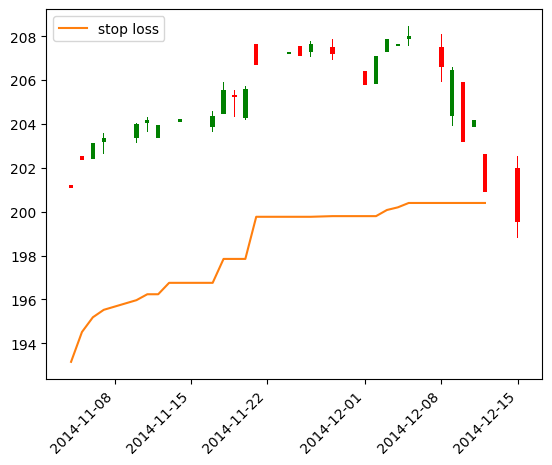

trade 37
entry: [206.42999267578125]
cost_basis: 206.42999267578125
exit: 203.00749969482422
returns: -0.016579436624465687


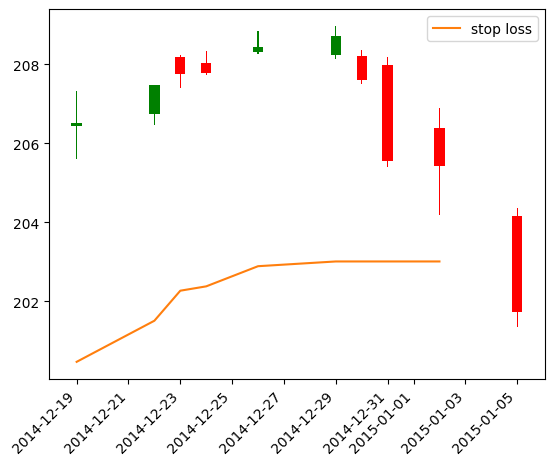

trade 38
entry: [213.2400054931641]
cost_basis: 213.2400054931641
exit: 207.6300010681152
returns: -0.026308404992180172


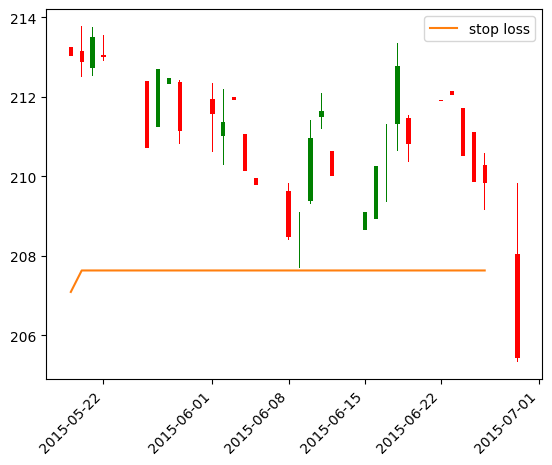

trade 39
entry: [210.25]
cost_basis: 210.25
exit: 199.37750244140622
returns: -0.05171223571269336


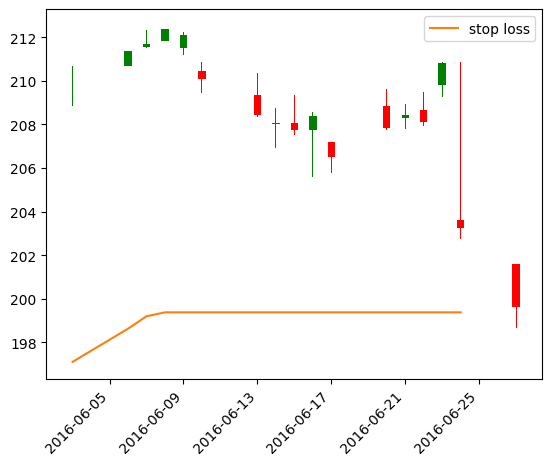

trade 40
entry: [213.19000244140625]
cost_basis: 213.19000244140625
exit: 267.3375205993652
returns: 0.25398713606582457


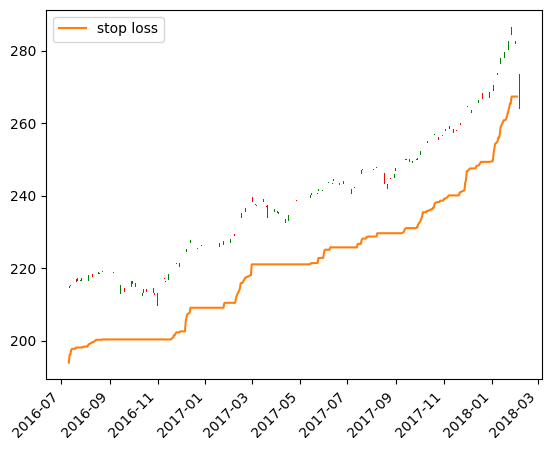

trade 41
entry: [281.3299865722656]
cost_basis: 281.3299865722656
exit: 275.8725051879883
returns: -0.019398861283048734


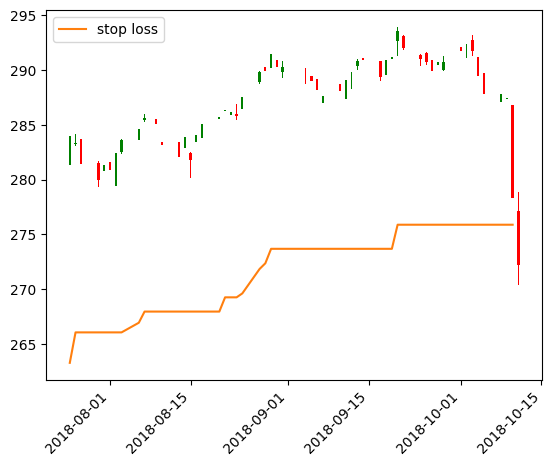

trade 42
entry: [286.0400085449219]
cost_basis: 286.0400085449219
exit: 280.04004669189453
returns: -0.02097595327153357


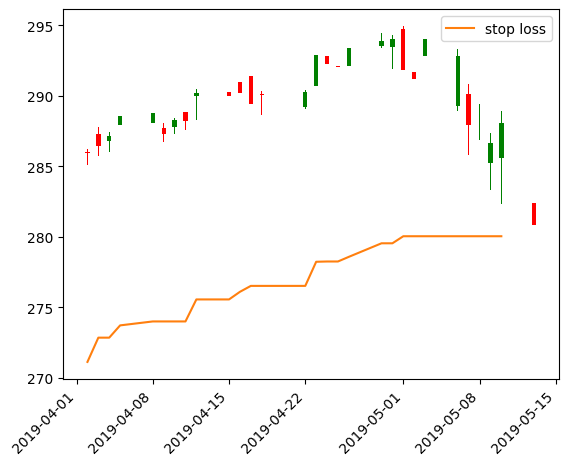

trade 43
entry: [294.1300048828125]
cost_basis: 294.1300048828125
exit: 304.7574996948242
returns: 0.036131964218495606


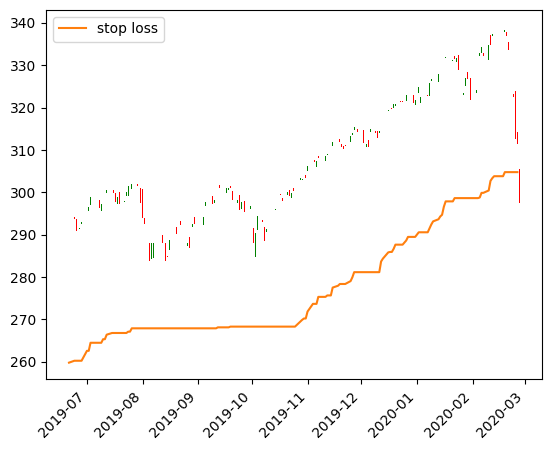

trade 44
entry: [335.0599975585937]
cost_basis: 335.0599975585937
exit: 336.80249786376953
returns: 0.005200562042238772


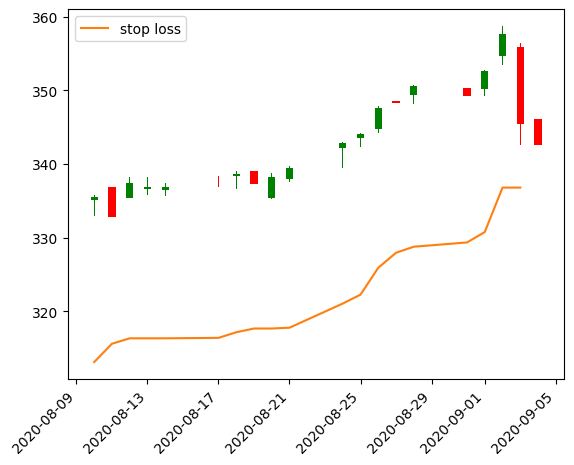

trade 45
entry: [353.489990234375]
cost_basis: 353.489990234375
exit: 449.4675064086914
returns: 0.2715140989160126


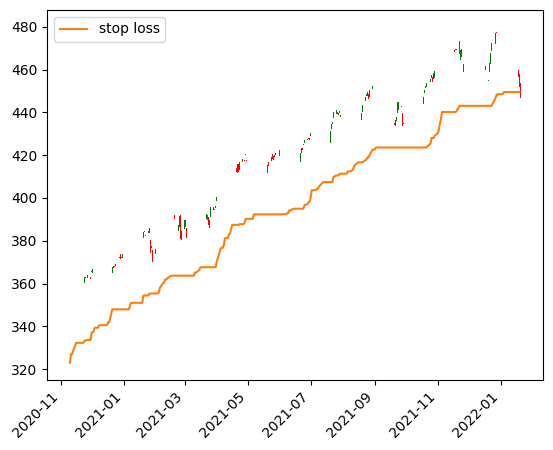

In [37]:
tl.plot_all_trades()

We can plot the trades that occur over a specific period of time to see how this strategy perform.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


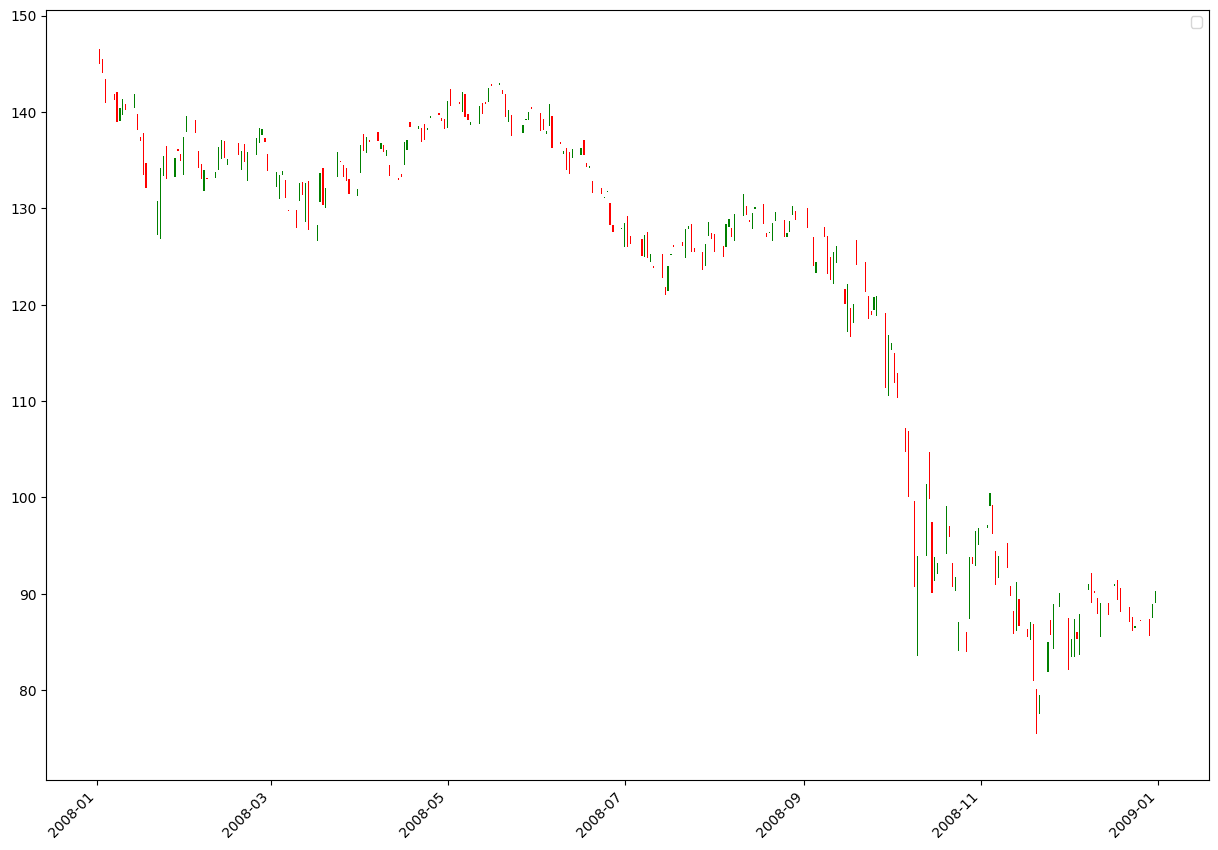

In [38]:

start_datetime= pd.to_datetime(dt.date(2008, 1, 1))
end_datetime = pd.to_datetime(dt.date(2009, 1, 1))

tl.plot_time_period(df, start_datetime, end_datetime)

We note that the time in trade for winning trades is generally higher than that of losing trades.

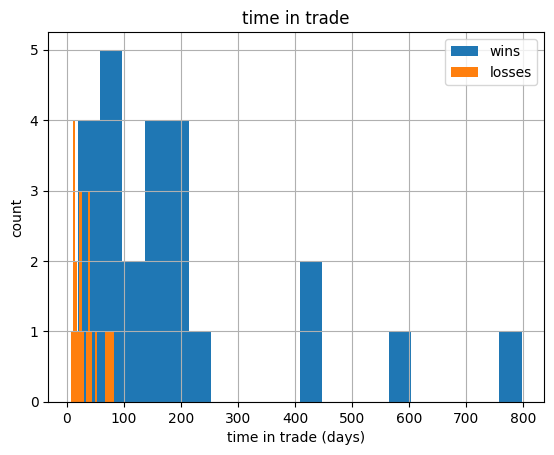

In [39]:
tl.win_records['time_in_trade'].hist(bins=20, label='wins')
tl.loss_records['time_in_trade'].hist(bins=20, label='losses')
plt.xlabel('time in trade (days)')
plt.ylabel('count')
plt.title('time in trade')
plt.legend()
plt.show()

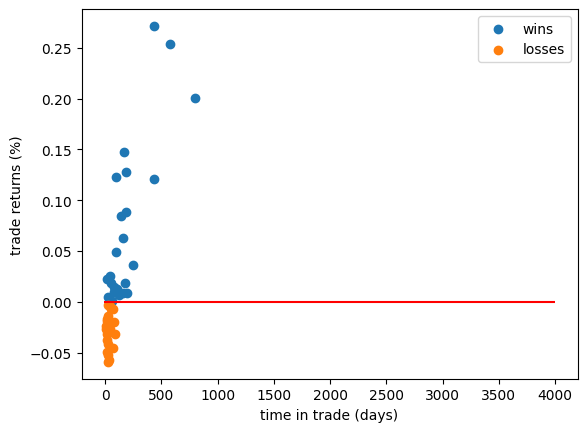

In [40]:
plt.scatter(tl.win_records['time_in_trade'], tl.win_records['returns'], label='wins')
plt.scatter(tl.loss_records['time_in_trade'], tl.loss_records['returns'], label='losses')
plt.hlines(0, -10, 4000, color='red')
plt.legend()
plt.xlabel('time in trade (days)')
plt.ylabel('trade returns (%)')
plt.show()

### Analysis

We note that the turtle trading rules follow a trend-following or momentum trading strategy. The characteristic of these strategies is greater volatility, with lower win-rate but higher returns per winning trade.

Ideally, the strategy goes long when a long-term upward trend is established and follows the trend until it is exhausted, while avoiding big drawdowns when long-term downward trends are established. 

The downside to this strategy is that short-term volatility is likely to cause whipsaw losses. An example of this is losses when the underlying is trading within a range.

Therefore, the way to optimise this strategy is to pick the underlying to more frequent long-term trends with greater magnitude compared to short-term volatility. It does not matter which direction that long-term trend is in since we can just inverse the rules, e.g. go short when price breaks out under the 20-day low. This is also possibly why the original turtle traders focused on commodity trading, since commodities tend to exhibit trends based on the physical demand and supply of the commodity, whereas equities may be more volatile in the short-term due to speculation.

Another key part to the success of this strategy is to trade diversified and uncorrelated assets so that the various assets will be trending at different times. This will go a long way towards reducing the volatility of a portfolio trading all of these assets.

Another idea is to trade this strategy on leveraged ETFs, for example UPRO (3 x leveraged SP500) instead of trading on SPY. The nature of the ETF (3 x daily returns) is likely to cause the magnitude of long-term trends to increase significantly, thus increasing the returns per winning trade of this strategy. The volatility drag of the leverage should also reduce the number of whipsaw losing trades. Therefore, the overall profitability of this strategy on leveraged ETFs should increase. More testing is required however, since we have to account for a higher expense ratio, tracking error, and a lack of historical data since these ETFs are a relatively recent invention.